# Volatility Surface Construction – Notebook 3
## SVI Model Definition & Implementation

### 3.1 Motivation: From Discrete Points to a Continuous Surface

In Notebook 2, we transformed market prices into implied volatilities. The result is a set of discrete points scattered across various strikes and maturities. However, pricing engines and risk management systems require a continuous, smooth surface that enables volatility queries at *any* strike and *any* maturity.

Simply interpolating between raw market points is dangerous. Market data is noisy, often contains arbitrage violations, and is sparse in the wings (deep ITM/OTM). We need a parametric model that:
1.  **Smooths** the microstructure noise.
2.  **Interpolates** between listed strikes.
3.  **Extrapolates** safely to strikes outside the market domain.
4.  **Guarantees** absence of arbitrage.

For equity indices like SPY, the industry standard for this task is the **Stochastic Volatility Inspired (SVI)** model.

### 3.2 Mathematical Framework

Before defining the SVI equation, we must establish the coordinate system. SVI does not model volatility ($\sigma$) directly; it models **Total Implied Variance** ($w$).

**1. Log-Moneyness ($k$)**
This is our spatial coordinate, centered around the forward price:
$$ k = \ln\left(\frac{K}{F_0(T)}\right) $$

**2. Total Implied Variance ($w$)**
This is our target variable. It represents the total accumulated variance over the life of the option:
$$ w(k, T) = \sigma_{imp}^2(K, T) \cdot T $$

Modeling variance ($w$) rather than volatility ($\sigma$) simplifies the mathematics, as total variance is naturally additive in time and avoids singularities as $T \to 0$.

### 3.3 The SVI Parameterization (Raw SVI)

The "Raw SVI" formulation, popularized by Jim Gatheral, models the total variance for a *fixed time slice* (a specific maturity $T$) as a non-linear function of log-moneyness $k$. 

The core equation is:

$$ w(k) = a + b \left( \rho (k - m) + \sqrt{(k - m)^2 + \sigma^2} \right) $$

This 5-parameter equation describes a hyperbola in the $(k, w)$ plane. Each parameter has a distinct economic interpretation:

* **$a$ (Level):** Controls the vertical translation. It represents the overall level of variance; increasing $a$ shifts the entire smile up (parallel shift).
* **$b$ (Angle):** Controls the angle between the two asymptotes of the hyperbola. It determines the amplitude of the smile.
* **$\rho$ (Skew):** Controls the rotation of the hyperbola. A negative $\rho$ (typical for equities) creates a downward sloping skew, reflecting the correlation between spot and volatility (leverage effect).
* **$m$ (Shift):** Controls the horizontal translation. It allows the minimum of the smile to sit away from ATM, $k=0$.
* **$\sigma$ (Curvature):** Controls the smoothness of the vertex (the bottom of the smile). It determines how rounded the smile is around the money.

The SVI model is favored by equity desks because it is parsimonious (only 5 parameters), flexible enough to capture steep equity skews, and generally robust to extrapolation.

The following diagram illustrates how these parameters shape the hyperbola asymptotes:



### 3.4 Implementation Overview: `src/svi.py`

The mathematical logic of SVI is encapsulated in `src/svi.py`. This module is designed to be:
1.  **Stateless:** It computes values based on inputs, storing no internal state.
2.  **Maturity-Agnostic:** It treats $T$ as a scaling factor, allowing the core logic to focus on the slice $w(k)$.
3.  **Vectorized:** It accepts arrays of strikes ($k$) for efficient batch computation.

We will now import the module and explore its key components.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Ensure local modules can be imported
sys.path.append(str(Path.cwd().parent))

from src.SVI import SVIParams, svi_total_variance, svi_implied_vol

### 3.5 Function Walkthrough

**1. `SVIParams` Data Class**
This simple data structure holds the 5 parameters ($a, b, \rho, m, \sigma$). Using a typed class ensures parameters are not accidentally swapped during optimization.

**2. `svi_total_variance(k, params)`**
This is the engine of the model. It implements the raw SVI formula directly. 
* **Input:** Array of log-moneyness $k$.
* **Output:** Total variance $w$.
Note that this function does not care for time $T$; it operates purely in the variance domain.

**3. `svi_implied_vol(k, T, params)`**
This wrapper reverts back to standard finance units. It calls `svi_total_variance` and then normalizes by time:
$$ \sigma_{imp} = \sqrt{\frac{\max(w, 0)}{T}} $$
The `max(w, 0)` check guards against numerical instabilities where variance might drift slightly negative during aggressive optimization steps.

### 3.6 Visual Intuition: Anatomy of a Smile

For intuition purposes, let's generate a hypothetical volatility smile using the implementation. We will set parameters typical for an equity index (high skew, negative $\rho$).

**Hypothetical Parameters:**
* $a = 0.04$ (Base variance level)
* $b = 0.4$ (Steep wings)
* $\rho = -0.7$ (Strong negative skew/correlation)
* $m = 0.1$ (Minimum variance shifted slightly to the right)
* $\sigma = 0.1$ (Smooth ATM curvature)

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matte\AppData\Local\Temp\ipykernel_6516\1022211633.py:24: SyntaxWarning: invalid escape sequence '\s'
  ax[1].set_title(f"Implied Volatility $\sigma_{{imp}}(k)$ (T={T_demo})")
C:\Users\matte\AppData\Local\Temp\ipykernel_6516\1022211633.py:26: SyntaxWarning: invalid escape sequence '\s'
  ax[1].set_ylabel("Implied Volatility $\sigma$")


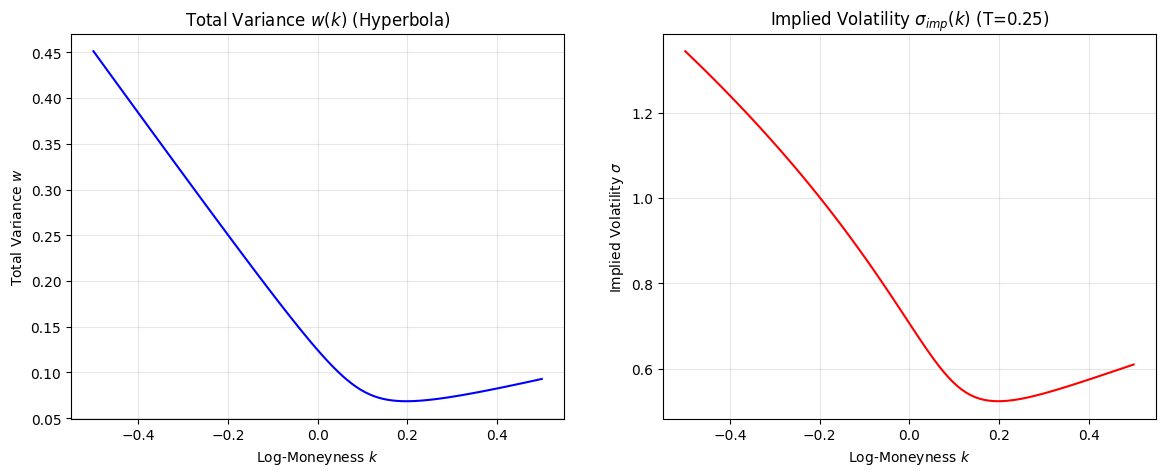

In [3]:
# 1. Define the simulation grid (Log-moneyness from -0.5 to 0.5)
k_grid = np.linspace(-0.5, 0.5, 100)
T_demo = 0.25  # 3 Months maturity

# 2. Define hypothetical parameters (Equity-like skew)
params = SVIParams(a=0.04, b=0.4, rho=-0.7, m=0.1, sigma=0.1)

# 3. Compute Total Variance and Implied Volatility using src/svi.py
total_variance = svi_total_variance(k_grid, params)
implied_vols = svi_implied_vol(k_grid, T_demo, params)

# 4. Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot A: Total Variance (The Hyperbola)
ax[0].plot(k_grid, total_variance, label="SVI Total Variance", color='blue')
ax[0].set_title("Total Variance $w(k)$ (Hyperbola)")
ax[0].set_xlabel("Log-Moneyness $k$")
ax[0].set_ylabel("Total Variance $w$")
ax[0].grid(True, alpha=0.3)

# Plot B: Implied Volatility (The Smile)
ax[1].plot(k_grid, implied_vols, label="SVI Implied Vol", color='red')
ax[1].set_title(f"Implied Volatility $\sigma_{{imp}}(k)$ (T={T_demo})")
ax[1].set_xlabel("Log-Moneyness $k$")
ax[1].set_ylabel("Implied Volatility $\sigma$")
ax[1].grid(True, alpha=0.3)

plt.show()

### 3.7 Conclusion & Next Steps

We have now defined the SVI model mathematically and verified that our implementation in `src/svi.py` behaves as expected, generating the characteristic "skewed smile" observed in equity markets.

**What is missing:**
1.  **Calibration:** We manually picked parameters above. In reality, we must find the optimal set $(a, b, \rho, m, \sigma)$ that minimizes the error between the model and market data.
2.  **Arbitrage Checks:** The SVI formula guarantees a smooth curve, but it does not automatically guarantee absence of static arbitrage (e.g., negative butterfly spreads). 

**Notebook 5** will tackle these challenges by building an optimization pipeline to fit this SVI model to the SPY data prepared in Notebook 1.